In [19]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-145201ef-f9fb-f34c-c53b-b326ff76d704)


In [20]:
from helper_functions import *

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteEV0TP9/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteEV0TP9/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
class_names = ds_info.features['label'].names

In [8]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
for image, label in train_data.take(1):
  print(image.shape, '\n', label, '\n', class_names[label.numpy()])

(512, 512, 3) 
 tf.Tensor(77, shape=(), dtype=int64) 
 pork_chop


In [10]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [11]:
import matplotlib.pyplot as plt

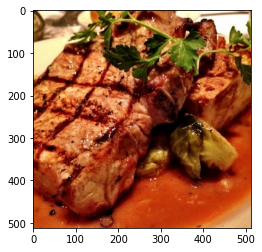

In [12]:
plt.imshow(image)

In [13]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, size=[img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [14]:
preprocessed_img = preprocess_img(image, label)

In [15]:
preprocessed_img

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 69.69388  ,  32.69388  ,  16.693878 ],
         [ 78.44898  ,  41.44898  ,  22.520409 ],
         [ 78.35204  ,  42.566326 ,  16.137754 ],
         ...,
         [211.34154  , 166.91301  , 141.69875  ],
         [172.38239  , 127.382385 , 104.382385 ],
         [138.04063  ,  93.040634 ,  72.040634 ]],
 
        [[ 63.693874 ,  28.290815 ,  10.499998 ],
         [ 60.137756 ,  25.137754 ,   3.2857132],
         [ 68.54082  ,  33.484695 ,   5.198978 ],
         ...,
         [208.20901  , 164.19371  , 136.76518  ],
         [184.3518   , 140.48448  , 113.76002  ],
         [146.6731   , 104.673096 ,  79.74452  ]],
 
        [[ 62.142857 ,  30.142857 ,   8.438776 ],
         [ 61.795918 ,  27.739798 ,   2.280612 ],
         [ 64.43878  ,  29.39286  ,   1.62245  ],
         ...,
         [160.42403  , 119.85259  ,  88.96486  ],
         [191.30092  , 150.72949  , 120.08663  ],
         [157.9994   , 118.999405 ,  87.57084 

In [16]:
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = test_data.map(map_func=preprocess_img,
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [18]:
checkpoint_path = 'logs/food101.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


In [21]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [25]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=(224,224,3), dtype=tf.float32, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [32]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=(test_data),
                    validation_steps=int(0.15*(len(test_data))),
                    callbacks=[create_tensorboard_callback(dir_name='logs', experiment_name='food101'),
                               model_checkpoint])

Saving TensorBoard log files to: logs/food101/20220811-193832
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8211 - accuracy: 0.5563

2368/2368 [==============================] - 198s 75ms/step - loss: 1.8211 - accuracy: 0.5563 - val_loss: 1.2278 - val_accuracy: 0.6761
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2930 - accuracy: 0.6672

2368/2368 [==============================] - 184s 77ms/step - loss: 1.2930 - accuracy: 0.6672 - val_loss: 1.1280 - val_accuracy: 0.6928
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1432 - accuracy: 0.7024

2368/2368 [==============================] - 171s 71ms/step - loss: 1.1432 - accuracy: 0.7024 - val_loss: 1.0889 - val_accuracy: 0.7100


In [33]:
model_results = model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 1.0847 - accuracy: 0.7086


In [35]:
model.save('saved_models')

In [38]:
loaded_model = tf.keras.models.load_model('saved_models')

In [39]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 68s 83ms/step - loss: 1.0847 - accuracy: 0.7086


[1.0847392082214355, 0.7085544466972351]

In [41]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d_1 True
dense_1 True
output_layer True


In [44]:
model.trainable=True

In [46]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb0 True <Policy "mixed_float16">
global_average_pooling2d_1 True <Policy "mixed_float16">
dense_1 True <Policy "mixed_float16">
output_layer True <Policy "float32">


In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
checkpoint_path = 'logs/food101_trainable.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


In [48]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [49]:
history_2 = model.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=(test_data),
                      validation_steps=int(0.15*(len(test_data))),
                      callbacks=[create_tensorboard_callback(dir_name='logs',experiment_name='food101_part2'),
                                 model_checkpoint,
                                 early_stopping])

Saving TensorBoard log files to: logs/food101_part2/20220811-201433
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.7513

2368/2368 [==============================] - 364s 146ms/step - loss: 0.9236 - accuracy: 0.7513 - val_loss: 0.8077 - val_accuracy: 0.7799
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.8406

2368/2368 [==============================] - 342s 144ms/step - loss: 0.5796 - accuracy: 0.8406 - val_loss: 0.7911 - val_accuracy: 0.7863
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.9063

2368/2368 [==============================] - 344s 145ms/step - loss: 0.3275 - accuracy: 0.9063 - val_loss: 0.8490 - val_accuracy: 0.7831
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9485

2368/2368 [==============================] - 342s 144ms/step - loss: 0.1743 - accuracy: 0.9485 - val_loss: 0.9386 - val_accuracy: 0.7826
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9669

2368/2368 [==============================] - 354s 149ms/step - loss: 0.1052 - accuracy: 0.9669 - val_loss: 1.0595 - val_accuracy: 0.7775


In [50]:
tuned_model_results = model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.0725 - accuracy: 0.7758


In [51]:
pred = model.predict(test_data)

In [55]:
class_names[pred[0].argmin()]

'french_onion_soup'

In [58]:
model.save('food101_finalModel')